# Part 3 - Algebraic reconstruction methods

So far, we have seen 2 image reconstruction methods:

* Fourier reconstruction
* Filtered back projection

These may not perform optimally when the sinogram is undersampled or noisy. We therefore consider an alternative, which attempts to solve the system of equations explicitly.

# Overview

* Richardson iteration
* Row-action methods
* Assignments

# Richardson iteration

We can attempt to solve a linear system of equations

$$Ku = f,$$

using the Richardon iteration

$$u^{(k+1)} = u^{(k)} - \alpha K^T(Ku^{(k)} - f).$$

When $u^{(0)} = 0$ and $0 < \alpha < 2/\|K\|^2$ it converges to the minimum-norm solution of the normal equations

$$K^T\!Ku = K^Tf.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def ray(n, s, theta):
    """
    Trace ray:
        x(t) =  t*sin(theta) + s*cos(theta)
        y(t) = -t*cos(theta) + s*sin(theta)
    through volume [-1,1]^2, discretised with n x n pixels.
    
    Returns linear indices of intersected pixels and corresponding intersection lengths
    """
    
    # define boundaries of pixels
    h = 2/n
    x = -1 + np.linspace(0,n,n+1)*h
    y = -1 + np.linspace(0,n,n+1)*h
    
    # compute all intersections with horizontal and vertical grid lines
    # in terms of path length parameter t
    t = []
    if np.abs(np.sin(theta)) > 0:
        tx = (x - s*np.cos(theta))/np.sin(theta)
        t = np.concatenate((t,tx))
    if np.abs(np.cos(theta)) > 0 :
        ty = -(y - s*np.sin(theta))/np.cos(theta)
        t = np.concatenate((t,ty))
    
    # sort t in increasing order
    t = np.sort(t[np.isfinite(t)])
    
    # now trace the ray and store pixel-indices and path lengths
    nt = len(t)
    I = []
    w = []
    for i in range(nt-1):
        # entry point of ray
        x1 = t[i]*np.sin(theta) + s*np.cos(theta)
        y1 = -t[i]*np.cos(theta) + s*np.sin(theta)
        
        # exit point of ray
        x2 = t[i+1]*np.sin(theta) + s*np.cos(theta)
        y2 = -t[i+1]*np.cos(theta) + s*np.sin(theta)
        
        # pixel indices
        ix = int(((x1 + x2)/2+1)//h)
        iy = int(((y1 + y2)/2+1)//h)
        
        # only take pixels in volume [-1,1]^2 in to account
        if (0 <= ix < n) and (0 <= iy < n):
            I.append(int(iy*n + ix))
            w.append(t[i+1] - t[i])
        
    return I,w

def Radon(u, n, s, theta):
    
    ns = len(s)
    nt = len(theta)
    # 
    f = np.zeros(ns*nt)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            f[i*ns + j] = np.array(w).dot(u[J])
    return f

def RadonTranspose(f, n, s, theta):
    
    ns = len(s)
    nt = len(theta)
    # 
    u = np.zeros(n*n)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            u[J] += np.array(w)*f[i*ns + j]
    return u

In [4]:
# parameters
nx = 26
na = 26
h = 2/nx
s = np.linspace(-1+h/2,1-h/2,nx)
theta = np.linspace(0,np.pi,na)
sigma = 0.1
niter = 100
alpha = .5

# Phantom
u = np.zeros((nx,nx))
u[nx//2-nx//6:2*nx//3+nx//7, nx//2-nx//8:2*nx//3+nx//8] = 1
u = u.ravel()

# Noisy data
f = Radon(u, nx, s, theta)
f_noisy = f + sigma * np.random.randn(len(f))

#  Richardson
r = np.zeros(niter)
e = np.zeros(niter)
u_rec = np.zeros(nx*nx)
for i in range(niter):
    res = Radon(u_rec, nx, s, theta) - f_noisy
    du  = RadonTranspose(res, nx, s, theta)
    u_rec -= alpha*du
    
    r[i] = np.linalg.norm(res)/np.linalg.norm(f_noisy)
    e[i] = np.linalg.norm(u_rec - u)/np.linalg.norm(u)

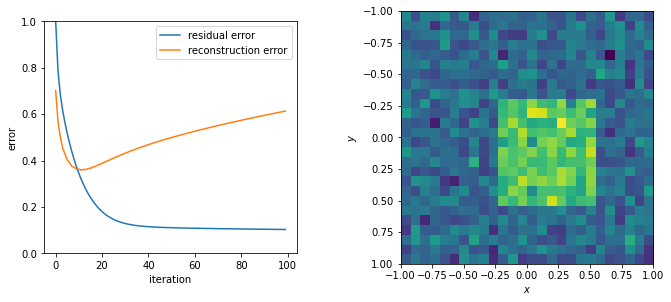

In [5]:
fig, ax = plt.subplots(1,2)

ax[0].plot(r,label='residual error')
ax[0].plot(e,label='reconstruction error')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('error')
ax[0].set_ylim([0,1])
ax[0].set_aspect(niter)
ax[0].legend()

ax[1].imshow(u_rec.reshape((nx,nx)),extent=(-1,1,1,-1))
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$y$')

fig.tight_layout()
fig.set_figwidth(10)

plt.savefig('./figures/lecture3/richardson_' + str(sigma) + '.png',dpi=300)

![](./figures/lecture3/richardson_0.png)

![](./figures/lecture3/richardson_0.1.png)

## Convergence

Convergence to a solution of the normal equations:

$$e^{(k+1)} = \left(I - \alpha K^T\!K \right)e^{(k)},$$

so error components corresponding to eigenvalues $\approx \alpha^{-1}$ decay fastest.

Convergence to the true solution:

$$e^{(k+1)} = \left(I - \alpha K^T\!K \right)e^{(k)} - \alpha K^T\epsilon.$$


## Computing the steplength

* Determine $\alpha$ such that the eigenvalues of $\left(I - \alpha K^T\!K \right)$ are $\in (-1,1)$
* let $\alpha \in (0, 2/\lambda_\max (K^T\!K) )$
* use that $(K^T\!K)^k v$ tends to largest eigenvector of $K^T\!K$ as $k\rightarrow \infty$
* use $\|K\|_2^2 \leq \|K\|_1 \|K\|_\infty$.

# Row-action methods

The computational cost of Richardson's method is dominated by the cost of the foward and adjoint Radon transform. Can we work with a single ray at a time?

The Kaczmarz method proceeds as follows:

$$u^{(k+1)} = u^{(k)} - \frac{f_i - k_i^Tu^{(k)}}{\|k_i\|_2^2} k_i^T,$$

with $k_i$ the $i^{\text{th}}$ row of $K$.

In [9]:
# parameters
nx = 26
na = 26
h = 2/nx
s = np.linspace(-1+h/2,1-h/2,nx)
theta = np.linspace(0,np.pi,na)
sigma = 0.1
niter = 10 * nx * na
alpha = .5

# Phantom
u = np.zeros((nx,nx))
u[nx//2-nx//6:2*nx//3+nx//7, nx//2-nx//8:2*nx//3+nx//8] = 1
u = u.ravel()

# Noisy data
f = Radon(u, nx, s, theta)
f_noisy = f + sigma * np.random.randn(len(f))

#  Kacmarz
e = np.zeros(niter)
u_rec = np.zeros(nx*nx)
i = 0
for i in range(niter):
        # 
        j = np.mod(i, nx*na)
        sj = j % na
        tj = j // na
        kj = RadonTranspose([1], nx, [s[sj]], [theta[tj]])
        
        u_rec += kj * (f_noisy[j] - kj.dot(u_rec))/np.linalg.norm(kj)**2

        e[i] = np.linalg.norm(u_rec - u)/np.linalg.norm(u)

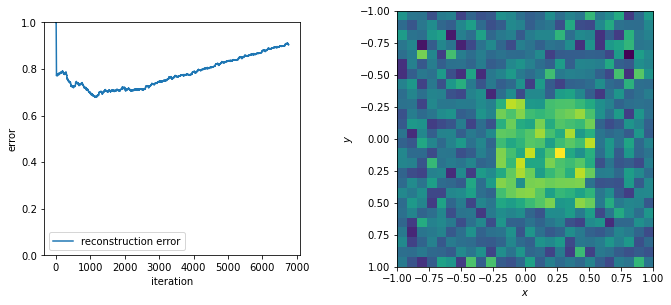

In [10]:
fig, ax = plt.subplots(1,2)

#ax[0].plot(r,label='residual error')
ax[0].plot(e,label='reconstruction error')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('error')
ax[0].set_ylim([0,1])
ax[0].set_aspect(niter)
ax[0].legend()

ax[1].imshow(u_rec.reshape((nx,nx)),extent=(-1,1,1,-1))
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$y$')

fig.tight_layout()
fig.set_figwidth(10)

plt.savefig('./figures/lecture3/kaczmarz_' + str(sigma) + '.png',dpi=300)

![](./figures/lecture3/kaczmarz_0.png)

![](./figures/lecture3/kaczmarz_0.1.png)

## Convergence

* Many results when system is consistent
* May not converge when system is inconsistent
* Relaxed version converges to solution to weighted least-squares problem